In [74]:
import json
import sys
from requests import Session, Request
from datetime import datetime, date, time, timedelta, timezone
from posixpath import join as urljoin
import pandas as pd
import io
from blume import client, station, measurements
from blume.station import Station
from sensemapi import client as sense_client
import matplotlib as plot
import numpy as np

ModuleNotFoundError: No module named 'pd'

## Load Data from BLUME into Pandas Datafram
- Load the newest Data from the Website
- Archive into local Data Storage
- Read all new and old Measurments from Data Storage
- Create Global Matrix (Time x Station = Measuremt)

In [2]:
#Scrape newest/available data from the Blume-Website
df = client.get_blume_measurments()
df = client.clean_data(df)

#Create Measurements and append to local storage of data (JSON)
online_measurement = client.create_measurements(df)

#Initially load all Stations from local storage (JSON)
station.init_stations()
#Source all available Information from local storage to pandas df
station_collection = Station.station_collection

#get all available station ids and use them to get all measurements from all
# stations
station_ids = [station.id for station in station_collection]
all_station_measurements = measurements.read_measurements_by_station_id_list(
    station_ids)

#from all measurements, get pandas series and combine to global matrix
df_local = [m.dataframe for m in all_station_measurements]
df_global = pd.concat(df_local, axis=1)


df_global.tail(10)

/home/kb/PycharmProjects/bachelorarbeit/Code/blume/client.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = cleand_dates
/home/kb/.virtualenvs/Code-ezpIWD29/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,10,32,42,77,85,88,117,124,143,171,174,220
2019-12-22 05:00:00,24,22.0,21,19,19,25,25.0,21,25,27,23.0,24
2019-12-22 06:00:00,25,21.0,21,18,13,26,23.0,20,24,23,23.0,24
2019-12-22 07:00:00,23,21.0,23,19,15,23,23.0,21,25,24,25.0,23
2019-12-22 08:00:00,22,21.0,23,19,14,22,23.0,20,27,23,25.0,26
2019-12-22 09:00:00,21,19.0,22,21,13,22,23.0,21,27,24,27.0,25
2019-12-22 10:00:00,21,19.0,27,22,12,24,22.0,23,31,28,28.0,25
2019-12-22 11:00:00,23,20.0,24,21,16,26,22.0,23,29,25,24.0,23
2019-12-22 12:00:00,22,19.0,21,22,20,26,23.0,22,26,19,23.0,22
2019-12-22 13:00:00,21,19.0,22,21,22,26,22.0,22,30,21,26.0,23
2019-12-22 14:00:00,22,18.0,23,21,20,28,22.0,23,32,22,30.0,29


In [3]:
df_global.index

DatetimeIndex(['2019-11-22 13:00:00', '2019-11-22 14:00:00',
               '2019-11-22 15:00:00', '2019-11-22 16:00:00',
               '2019-11-22 17:00:00', '2019-11-22 18:00:00',
               '2019-11-22 19:00:00', '2019-11-22 20:00:00',
               '2019-11-22 21:00:00', '2019-11-22 22:00:00',
               ...
               '2019-12-22 05:00:00', '2019-12-22 06:00:00',
               '2019-12-22 07:00:00', '2019-12-22 08:00:00',
               '2019-12-22 09:00:00', '2019-12-22 10:00:00',
               '2019-12-22 11:00:00', '2019-12-22 12:00:00',
               '2019-12-22 13:00:00', '2019-12-22 14:00:00'],
              dtype='datetime64[ns]', length=722, freq=None)

# Test 1: Compare Hourly mean for all of Berlin at a specific Hour
First, define statistical Variables
Be careful with BLUME Dates: When you ask for 14:00, it means you receive the mean from 13:00-14:00.

In [4]:
#SenseMapi related
example_to_date = datetime(2019, 11, 30, 12, 00, 00, 000)
example_from_date = example_to_date - timedelta(hours=1)
bbox_berlin = [13.0883, 52.3383, 13.7612, 52.6755]
#BLUME related
example_date = pd.Timestamp(example_from_date)
example_mean = df_global.loc[example_date]

## Load all PM10 Values from Berlin (OSeM) into DataFrame
- Create Request according to Statistical Parameters
- From all Sensors, Flatten the 
- Convert everything to Pandas Dataframe

In [5]:
senseMapiresponse = sense_client.SenseMapClient().get_measurements_by_phenomenon(
    bbox=bbox_berlin,
    phenomenon="PM10",
    from_date=example_from_date,
    to_date=example_to_date)

# Load all PM10 Values from Berlin (OSeM) into DataFrame
sensor_vals_df = [i.series for i in senseMapiresponse]
final_df = pd.concat(sensor_vals_df, axis=1)

In [6]:
final_df.describe()

,590b8480dd09cc0011aa79cd_PM10,591ecdc251d3460011651ffa_PM10,592ca4b851d3460011ea2636_PM10,593458ddad0fa30011ea0962_PM10,5936c52aad0fa30011033d68_PM10,594c01c7be77820011792181_PM10,5984c712e3b1fa001069150d_PM10,5998a7bad67eb500114b7d7b_PM10,599f3364d67eb50011b85cd4_PM10,59b9030bd67eb500117a3ff2_PM10,...,5d78d78f953683001a412c22_PM10,5d8a549d5f3de0001a7c3509_PM10,5d9ef41e25683a001ad916c7_PM10,5d9f216425683a001ae684cf_PM10,5da0a27f25683a001a59271d_PM10,5da202ac25683a001ac232e9_PM10,5dbf1a8ca68df4001adead33_PM10,5dc5d2d37d4ff7001ac78624_PM10,5dcbe2d1306947001a2c353f_PM10,5dd810224ec04e001a2212a3_PM10
count,23.000000,24.000000,23.000000,23.000000,12.000000,23.000000,24.000000,24.000000,57.000000,23.000000,...,10.000000,23.000000,24.000000,53.000000,4.000000,11.000000,23.000000,24.000000,23.000000,21.000000
mean,19.437391,23.472083,1.813478,5.350000,10.738333,9.293478,24.571667,14.976667,30.254211,7.297826,...,14.379000,24.690435,22.725833,15.424151,23.550000,15.749091,10.267826,17.506667,19.283043,19.263333
std,16.044018,4.572607,0.649941,1.687039,1.561921,2.659926,6.969347,3.024002,25.608425,0.433579,...,5.985582,6.199901,3.547336,2.367984,2.937686,4.508269,2.135435,3.406627,3.037295,2.579177
min,10.130000,14.900000,1.230000,3.970000,8.730000,5.230000,14.270000,10.270000,17.150000,6.730000,...,8.370000,16.370000,18.170000,10.800000,20.600000,8.900000,6.450000,11.100000,13.850000,14.150000
25%,13.750000,21.055000,1.350000,4.270000,9.777500,7.880000,20.342500,12.602500,23.420000,7.015000,...,10.862500,19.920000,20.517500,13.630000,22.175001,13.185000,9.090000,15.422500,17.600000,17.330000
50%,16.020000,23.950000,1.500000,4.700000,10.085000,8.630000,23.100000,14.415000,26.200000,7.100000,...,13.515000,23.870000,22.150000,15.800000,23.000000,13.930000,9.650000,17.520000,18.980000,19.730000
75%,18.625000,26.772500,2.070000,5.885000,12.297500,9.765000,28.335000,16.740000,29.230000,7.450000,...,15.755000,27.025000,23.417500,17.120000,24.374999,19.435000,11.660000,19.702500,21.025000,20.750000
max,91.350000,31.430000,3.630000,11.430000,12.930000,16.300000,45.600000,21.300000,214.400000,8.570000,...,29.100000,40.450000,30.800000,20.730000,27.600000,23.470000,14.650000,24.200000,25.980000,23.700000


## Results

In [7]:
print("Gesamt Berliner Feinstaubmittelwert am {} von {} bis {} Uhr"
    .format(
    example_date.strftime('%d.%m.%Y'),
    (example_date - timedelta(hours=1)).strftime('%H'),
    example_date.strftime('%H')
    )
)
print("Umweltbundesamt\t= {}"
    .format(example_mean.mean())
)
print("OpenSenseMap\t= {}"
    .format(final_df.mean().mean())
)

Gesamt Berliner Feinstaubmittelwert am 30.11.2019 von 10 bis 11 Uhr
Umweltbundesamt	= 20.583333333333332
OpenSenseMap	= 13.438895301385577


# Test 2: Compare Hourly mean for all of Berlin for 24 Hours
Same as Test 1, but now for the whole day, to see if there is a time where the relation is good / bad

In [35]:
#SenseMapi related
example_to_date = datetime(2019, 12, 12, 00, 00, 00, 000)
example_from_date = example_to_date - timedelta(hours=24)
#BLUME related: Careful adjuste the dates! BLUME publishes the hourly mean for 13:00 - 14:00 as 14:00
blume_start_date = pd.Timestamp(example_from_date)
blume_end_date = pd.Timestamp(example_to_date - timedelta(hours=1))

# Load from BLUME and create DataFrame
- Load the Data for the specified 24h
- Create Dataframe with the mean of every hour

In [36]:
mask = (df_global.index >= blume_start_date) & (df_global.index <= blume_end_date)
blume_hourly = df_global.loc[mask]
blume_hourly

,10,32,42,77,85,88,117,124,143,171,174,220
2019-12-11 00:00:00,19,14.0,17,19,13,17,19.0,18,21,19,24.0,17
2019-12-11 01:00:00,17,14.0,15,19,13,17,18.0,17,20,18,23.0,16
2019-12-11 02:00:00,16,14.0,15,18,12,17,18.0,15,18,18,22.0,15
2019-12-11 03:00:00,15,13.0,13,16,11,15,16.0,14,17,16,19.0,14
2019-12-11 04:00:00,12,12.0,11,14,9,13,14.0,13,15,14,16.0,12
2019-12-11 05:00:00,11,10.0,10,13,7,12,12.0,12,14,12,15.0,11
2019-12-11 06:00:00,10,10.0,9,13,8,14,12.0,14,14,11,15.0,11
2019-12-11 07:00:00,11,9.0,10,13,9,18,14.0,18,20,11,17.0,13
2019-12-11 08:00:00,12,9.0,11,14,9,16,16.0,18,26,12,20.0,14
2019-12-11 09:00:00,14,10.0,12,16,10,18,17.0,20,23,15,30.0,29


## Load all PM10 Values from Berlin (OSeM) into DataFrame
Same like above, but with much larger Dataset (Response Time might be longer).

In [10]:
senseMapiresponse = sense_client.SenseMapClient().get_measurements_by_phenomenon(
    bbox=bbox_berlin,
    phenomenon="PM10",
    from_date=example_from_date,
    to_date=example_to_date)

# Load all PM10 Values from Berlin (OSeM) into DataFrame
sensor_vals_df = [i.series for i in senseMapiresponse]
final_df = pd.concat(sensor_vals_df, axis=1)

Generate the Hourly-Mean for the given 24h interval of all Sensors in Berlin

In [69]:
#Using right label because BLUME does the same... Be careful, don't mix up the periods
hourly_sensors = final_df.resample('60T', label='right').mean()
hourly_sensors.head()

,591ecdc251d3460011651ffa_PM10,592ca4b851d3460011ea2636_PM10,593458ddad0fa30011ea0962_PM10,5936c52aad0fa30011033d68_PM10,594c01c7be77820011792181_PM10,595178fb94f0520011e083ed_PM10,5984c712e3b1fa001069150d_PM10,5998a7bad67eb500114b7d7b_PM10,599f3364d67eb50011b85cd4_PM10,59b9030bd67eb500117a3ff2_PM10,...,5d8a549d5f3de0001a7c3509_PM10,5d9ef41e25683a001ad916c7_PM10,5d9f216425683a001ae684cf_PM10,5da0a27f25683a001a59271d_PM10,5da202ac25683a001ac232e9_PM10,5dbf1a8ca68df4001adead33_PM10,5dc5d2d37d4ff7001ac78624_PM10,5dcbe2d1306947001a2c353f_PM10,5dd810224ec04e001a2212a3_PM10,5ded15e22b3516001a35dad2_PM10
2019-12-11 00:00:00,20.689565,9.900000,NaN,14.444167,17.247500,18.999167,24.155000,19.642500,20.457636,7.216957,...,19.696250,NaN,18.009630,28.750000,15.570000,17.037500,16.954348,28.263478,21.098261,138.020000
2019-12-11 01:00:00,19.544583,11.552917,NaN,15.643333,17.359091,19.325000,24.452083,19.963750,20.132909,7.132174,...,18.967917,NaN,17.920727,26.425001,16.191667,18.063636,17.977273,29.086957,21.480000,131.409130
2019-12-11 02:00:00,20.674783,11.908261,NaN,15.837500,16.292609,18.957826,23.498750,16.518333,18.647925,6.781250,...,19.482917,NaN,16.536182,24.299999,12.163636,16.025652,15.672174,27.661304,20.309583,108.567083
2019-12-11 03:00:00,16.204583,10.213478,NaN,8.932500,12.335217,15.267500,18.443333,14.825833,14.683818,6.935652,...,15.732500,NaN,15.540741,20.550000,14.033333,16.262083,12.452083,22.073043,15.611818,88.941667
2019-12-11 04:00:00,14.102917,8.425000,NaN,8.863636,9.632500,11.722273,14.563913,12.618182,12.400714,6.684583,...,13.856667,NaN,13.780556,16.075000,9.650000,12.705652,12.473750,18.954783,14.103043,74.079583


For every Hour, get the mean value of all sensor in Berlin in the specified 24h period - both for osem and for blume

In [12]:
hourly_sensor_mean = hourly_sensors.mean(axis=1)
hourly_sensor_mean.name="OSeM"
hourly_blume_mean = blume_hourly.mean(axis=1)
hourly_blume_mean.name="BLUME"

Now Append the hourly means from BLUME and append as a second colum to the data-set

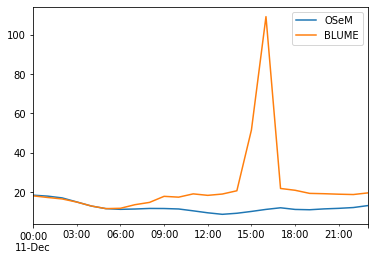

In [13]:
blume_vs_osem_hourly = pd.concat([hourly_sensor_mean, hourly_blume_mean], axis=1)
blume_vs_osem_hourly.plot()

Auf den ersten Blick fällt folgendes auf:
1. bis ca. 6 Uhr Frühs sind die Sensoren des OSeM und des BLUME fast identisch.
2. Um ca. 15:00 bis 17:00 hat das BLUME einen Ausreißer.
3. Es ergeben sich unterschiedliche Kurvenverläuf, mit leicht ähnlichen Ausschlagstendenzen

Zu Punkt 2: Was genau ist die Ursache dieses extremen Ausschlags? Schauen wir exemplarisch zur Uhrzeit 15 - 17 an diesem Tag die Messdaten aller BLUME-Sensoren an:

In [38]:
#BLUME related: Careful adjuste the dates! BLUME publishes the hourly mean for 13:00 - 14:00 as 14:00
end_exception = pd.Timestamp(2019, 12, 11, 17)
start_exception = pd.Timestamp(end_exception - timedelta(hours=4))
mask_exception = (df_global.index >= start_exception) & (df_global.index <= end_exception)
blume_hourly_exception = df_global.loc[mask_exception]
blume_hourly_exception

,10,32,42,77,85,88,117,124,143,171,174,220
2019-12-11 13:00:00,15,10.0,19,14,11,19,23.0,19,27,17,29.0,25
2019-12-11 14:00:00,16,11.0,19,15,11,19,18.0,25,30,17,43.0,24
2019-12-11 15:00:00,16,11.0,18,16,11,20,20.0,23,27,20,415.0,22
2019-12-11 16:00:00,14,12.0,18,17,11,20,21.0,23,31,19,1102.0,23
2019-12-11 17:00:00,16,13.0,18,21,11,23,21.0,23,34,19,36.0,27


Es ist erkennbar, dass die Messtation 174 in 2 Stunden deutliche Ausreiser hat. Aufgrund ihres Hohen Messwertes beeinflussen diese Werte die Messwerte der anderen Stationen. Streitbar ist, ob solche Werte das Ergebnis verälschen, denn Sie passieren ja auf beiden Seiten. Im Folgenden wird versucht, die Daten von beiden Quellen von Ausreisern zu befreien.

## BLUME: Entferne Ausreißer
Prinzipiell sind die Daten der BLUME als sehr akkurat zu betrachten. Außerdem sind die Werte schon vor der Veröffentlichung auf ein Stundenmittel hochgerechnet worden. Das bedeutet, dass wenn im BLUME Datensatz ein Ausreißer ist, dann war an der Messstation über mind. eine Stunde hinweg eine starke Feinstaubkonzentration. Das kann entweder an einem verfälschtem Messergebnis oder an einer kurzfristigen Quelle starker Exposition (Baustelle, Brand) gelegen haben.

Wenn aber einzelne Messwerte deutlich über 200 Liegen, ist davon auszugehen, dass es sich hierbei um einen Ausreiser mit Fremdeinwirkung handelt (Baustelle, Zigarette) der so Hyperlokal ist, dass er nicht in einen Berlinweiten Vergleich passt.

In [67]:
blume_hourly_cleaned = blume_hourly[blume_hourly < 200]

## OSeM: Entferne Außreiser
Aufgrund der hohen Zeitlichen Auflösung der OSeM Daten, fallen Außreiser weniger ins Gewicht. Da die Daten aber nicht schon vorab auf Stundenwerte gemittelt wurden wie bei BLUME-Messwerten, können Außreiser anhand der Nachbar-Messwerte leicht identifiziert werden. Das macht insbesondere deswegen Sinn, weil davon ausgegangen wird dass OSeM Messgeräte nicht dieselbe Präzision in der Bedienung erfahren wie die von BLUME. Kurze Ausreißer können z.B. davon kommen, dass eine Person vom Nachbarbalkon Zigarettenrauch in den Sensor bläßt.
Nachdem alle Außreiser von einem Sensor elimiert wurden, kann auch noch geprüft werden ob ein Sensor insgesamt Falsche Werte liefert. Wenn dieser z.B. im Betrachtungszeitraum im Median < 1 misst, kann dieser gefiltert werden. Hier muss aber besonders vorsichtig gefiltert werden, denn wenn z.B. eine Hintergrund- oder Waldstation insgesamt einen Median < 3 liefert, kann das durchaus realistisch.

In [89]:
#Using right label because BLUME does the same... Be careful, don't mix up the periods
final_df.mean().sort_values(ascending=True).head(20)

5bf93be1a8af82001afc156a_PM10    0.000000
5bf837bf86f11b001aae7f84_PM10    0.009527
5bf93c42a8af82001afc2a99_PM10    0.032868
5bf8373386f11b001aae6280_PM10    0.059306
5c016861ccc67b001c8a2d3b_PM10    0.110486
5c01676accc67b001c89f9f1_PM10    0.237648
5a915e10bc2d410019b1955c_PM10    0.278536
5c0e923e919bf8001abda1de_PM10    2.957957
5a7ebe55398b8200117cd3ac_PM10    3.225382
5d6e465a953683001a2b62c7_PM10    4.360989
5c30e2262c8010001936858a_PM10    5.142761
592ca4b851d3460011ea2636_PM10    5.835221
5d5929a0953683001a26e017_PM10    5.977220
593458ddad0fa30011ea0962_PM10    6.162324
59ff7429d13da40010178baf_PM10    6.330317
5bf93d62a8af82001afc650d_PM10    6.372708
5a914cfabc2d410019af575a_PM10    6.490202
5aa68042396417001bcc3503_PM10    6.707679
5cd5576eff898b001a1f1d04_PM10    6.719012
59b9030bd67eb500117a3ff2_PM10    6.889244
dtype: float64